In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#wmt modes
# process_gen_mode="wmt_single"
# process_gen_mode="wmt_samples"
# process_gen_mode="wmt_single"
# process_gen_modes=["wmt_samples0", "wmt_samples1", "wmt_samples2_1","wmt_samples2_2"]

# process_gen_mode="wmt_sample_100"
# process_gen_mode="wmt_sample_50"
    # wmt_sample_100
    
# compare_metric="example_comet"
# compare_metric="BLEU_4"


# process_gen_modes=["gsm_samples1","gsm_samples2","gsm_samples3"]
process_gen_modes=["wmt_samples0"]
do_norm_analysis=True
processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
examples_df, completions_df=get_dfs(processGens)


dfs_by_model={}

for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    filtered_df["rank"]=100-filtered_df["example_idx"]
    dfs_by_model[model_name]=filtered_df

all_dfs_by_model=dfs_by_model

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode ['wmt_samples0']
calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_1000/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_100_eval_1000
get_metrics_dict
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'rank', 'suite', 'instanceID', 'text', 'completion_length',
       'output_logprob', 'isCompletion'],
      dtype='object')
Num examples: 100000
Num completions: 1000


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

df=next(iter(dfs_by_model.values()))

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['meta_llama_Llama_3.1_8B_Instruct'] 
 	 custom_metrics[]
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_100_eval_1000 
 	 instance_metrics ['comet']
   example_comet  beam_num                    task_name  \
0       0.865341         1  wmt_14_language_pair_de_en_   
1       0.861965         1  wmt_14_language_pair_de_en_   

                              model  example_idx  rank                 suite  \
0  meta_llama_Llama_3.1_8B_Instruct            0   100  sample_100_eval_1000   
1  meta_llama_Llama_3.1_8B_Instruct            1    99  sample_100_eval_1000   

   instanceID                                               text  \
0           0  He advised the parents of a boy whose penis ha...   
1           0  He advised the parents of a boy whose penis wa...   

   completion_length  output_logprob isCompletion  
0                178       -8.308031         True  
1                177   

Text(0, 0.5, 'example_comet')

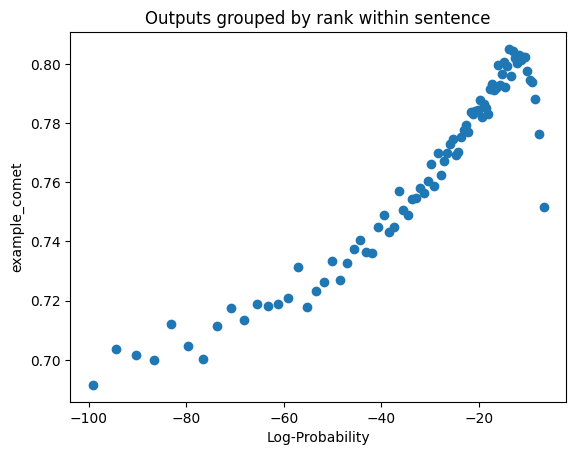

In [3]:
def plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=True):
    if(ax is None):
        _, ax = plt.subplots()
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    x = grouped[(xlabel, 'mean')]
    y = grouped[(ylabel, 'mean')]
    yerr = grouped[(ylabel, 'std')]

    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        if c>0:
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)
    if error_bar:
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)

    # plt.scatter(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if(title):
        ax.set_title(title)

    if(trend_line=="None"):
        pass
    elif(trend_line=="linear"):
        try:
            ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        except:
            pass
    else: 
        raise Exception("Plot_keys errors: did not recognize trend_line type")
        
    return ax, grouped


# df = df.head(10)
compare_metric="example_comet"
fig, ax = plt.subplots()
suptitle=f"Outputs grouped by rank within sentence"

top_df = df[df['example_idx']<85]
ax, grouped =plot_grouped(df=top_df, xlabel="output_logprob",groupby='example_idx', ylabel=compare_metric, title=suptitle, ax=ax, error_bar=False)
ax.set_xlabel("Log-Probability")
ax.set_ylabel(compare_metric)



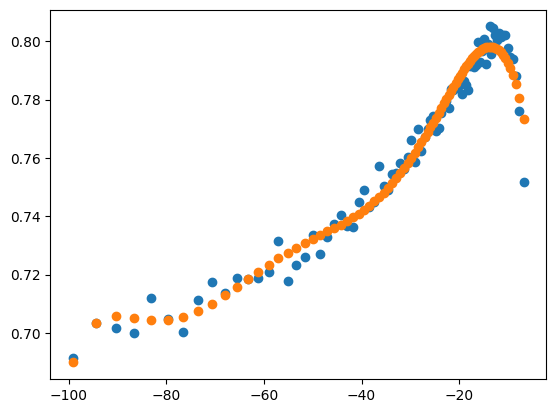

In [4]:
import numpy as np

def fit_poly(df, xlabel, ylabel, groupby):
# X: log-probabilities, y: example_comet
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    yerr = grouped[(ylabel, 'std')].values

    coeff=np.polyfit(x, y, 6)
    # print(coeff)
    mymodel = np.poly1d(coeff)



    plt.scatter(x, y)
    plt.scatter(x, mymodel(x))
    plt.show()

fit_poly(top_df,xlabel="output_logprob", ylabel=compare_metric,groupby="example_idx")

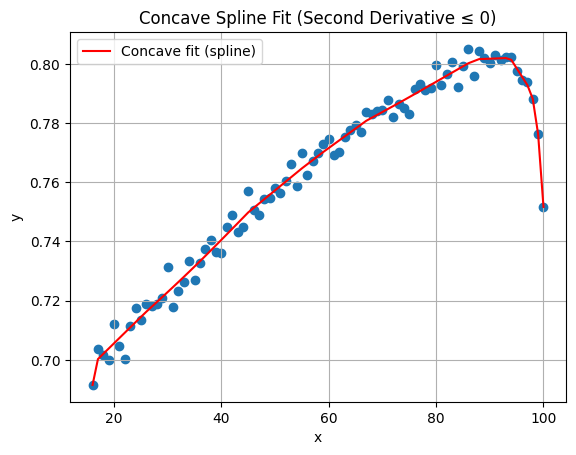

In [5]:
import numpy as np


def plot_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots()
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    x = grouped[(xlabel, 'mean')]
    y = grouped[(ylabel, 'mean')]
    yerr = grouped[(ylabel, 'std')]


    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)

    y_fit = cp.Variable(len(x))

    def get_diffs(a):
        return a[:-1]-a[1:]
    second_diffs=get_diffs(get_diffs(y_fit))
    objective = cp.Minimize(cp.sum_squares(y_fit - y))
    constraints = [second_diffs <= 0]  
    prob = cp.Problem(objective, constraints)
    prob.solve()


    ax.plot(x, y_fit.value, '-r', label='Concave fit (spline)')
    ax.set_title("Concave Spline Fit (Second Derivative ≤ 0)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True)


plot_spline(df=top_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle)




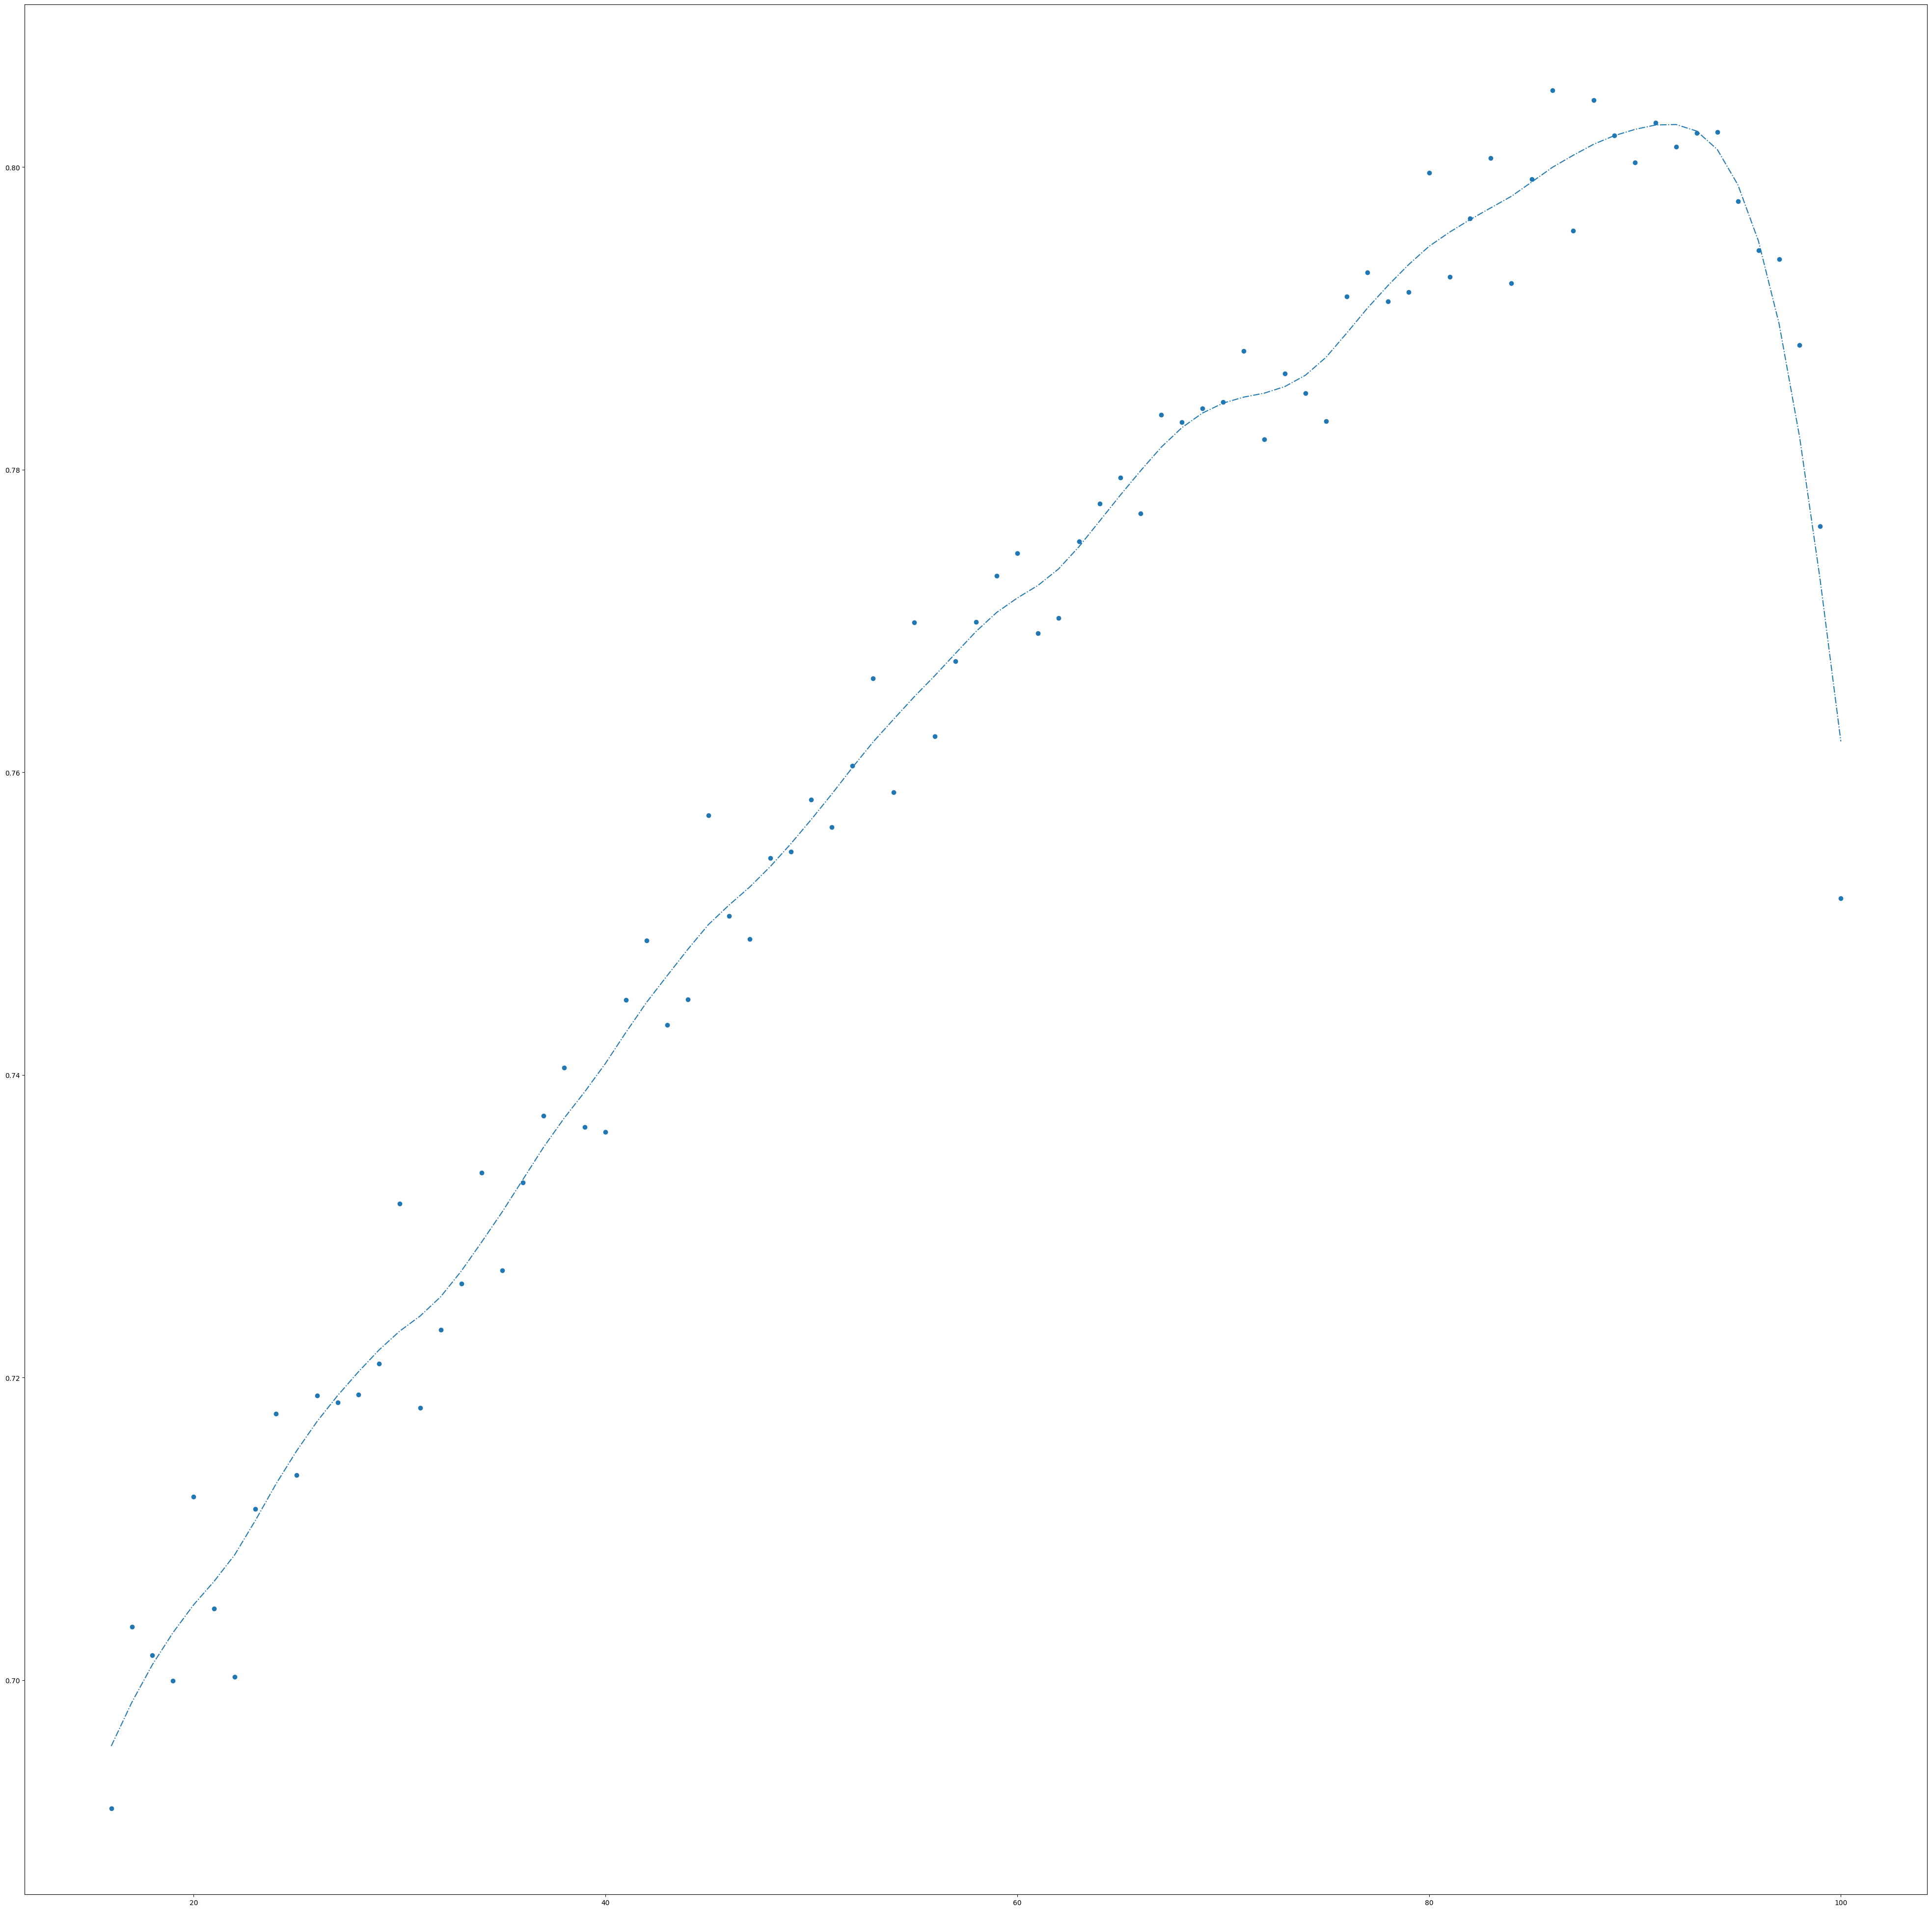

In [6]:
from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(50, 50))
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)
    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    plt.plot(x, spl(x), '-.')


plot_smooth_spline(df=top_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle)

/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_50645/2333726926.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


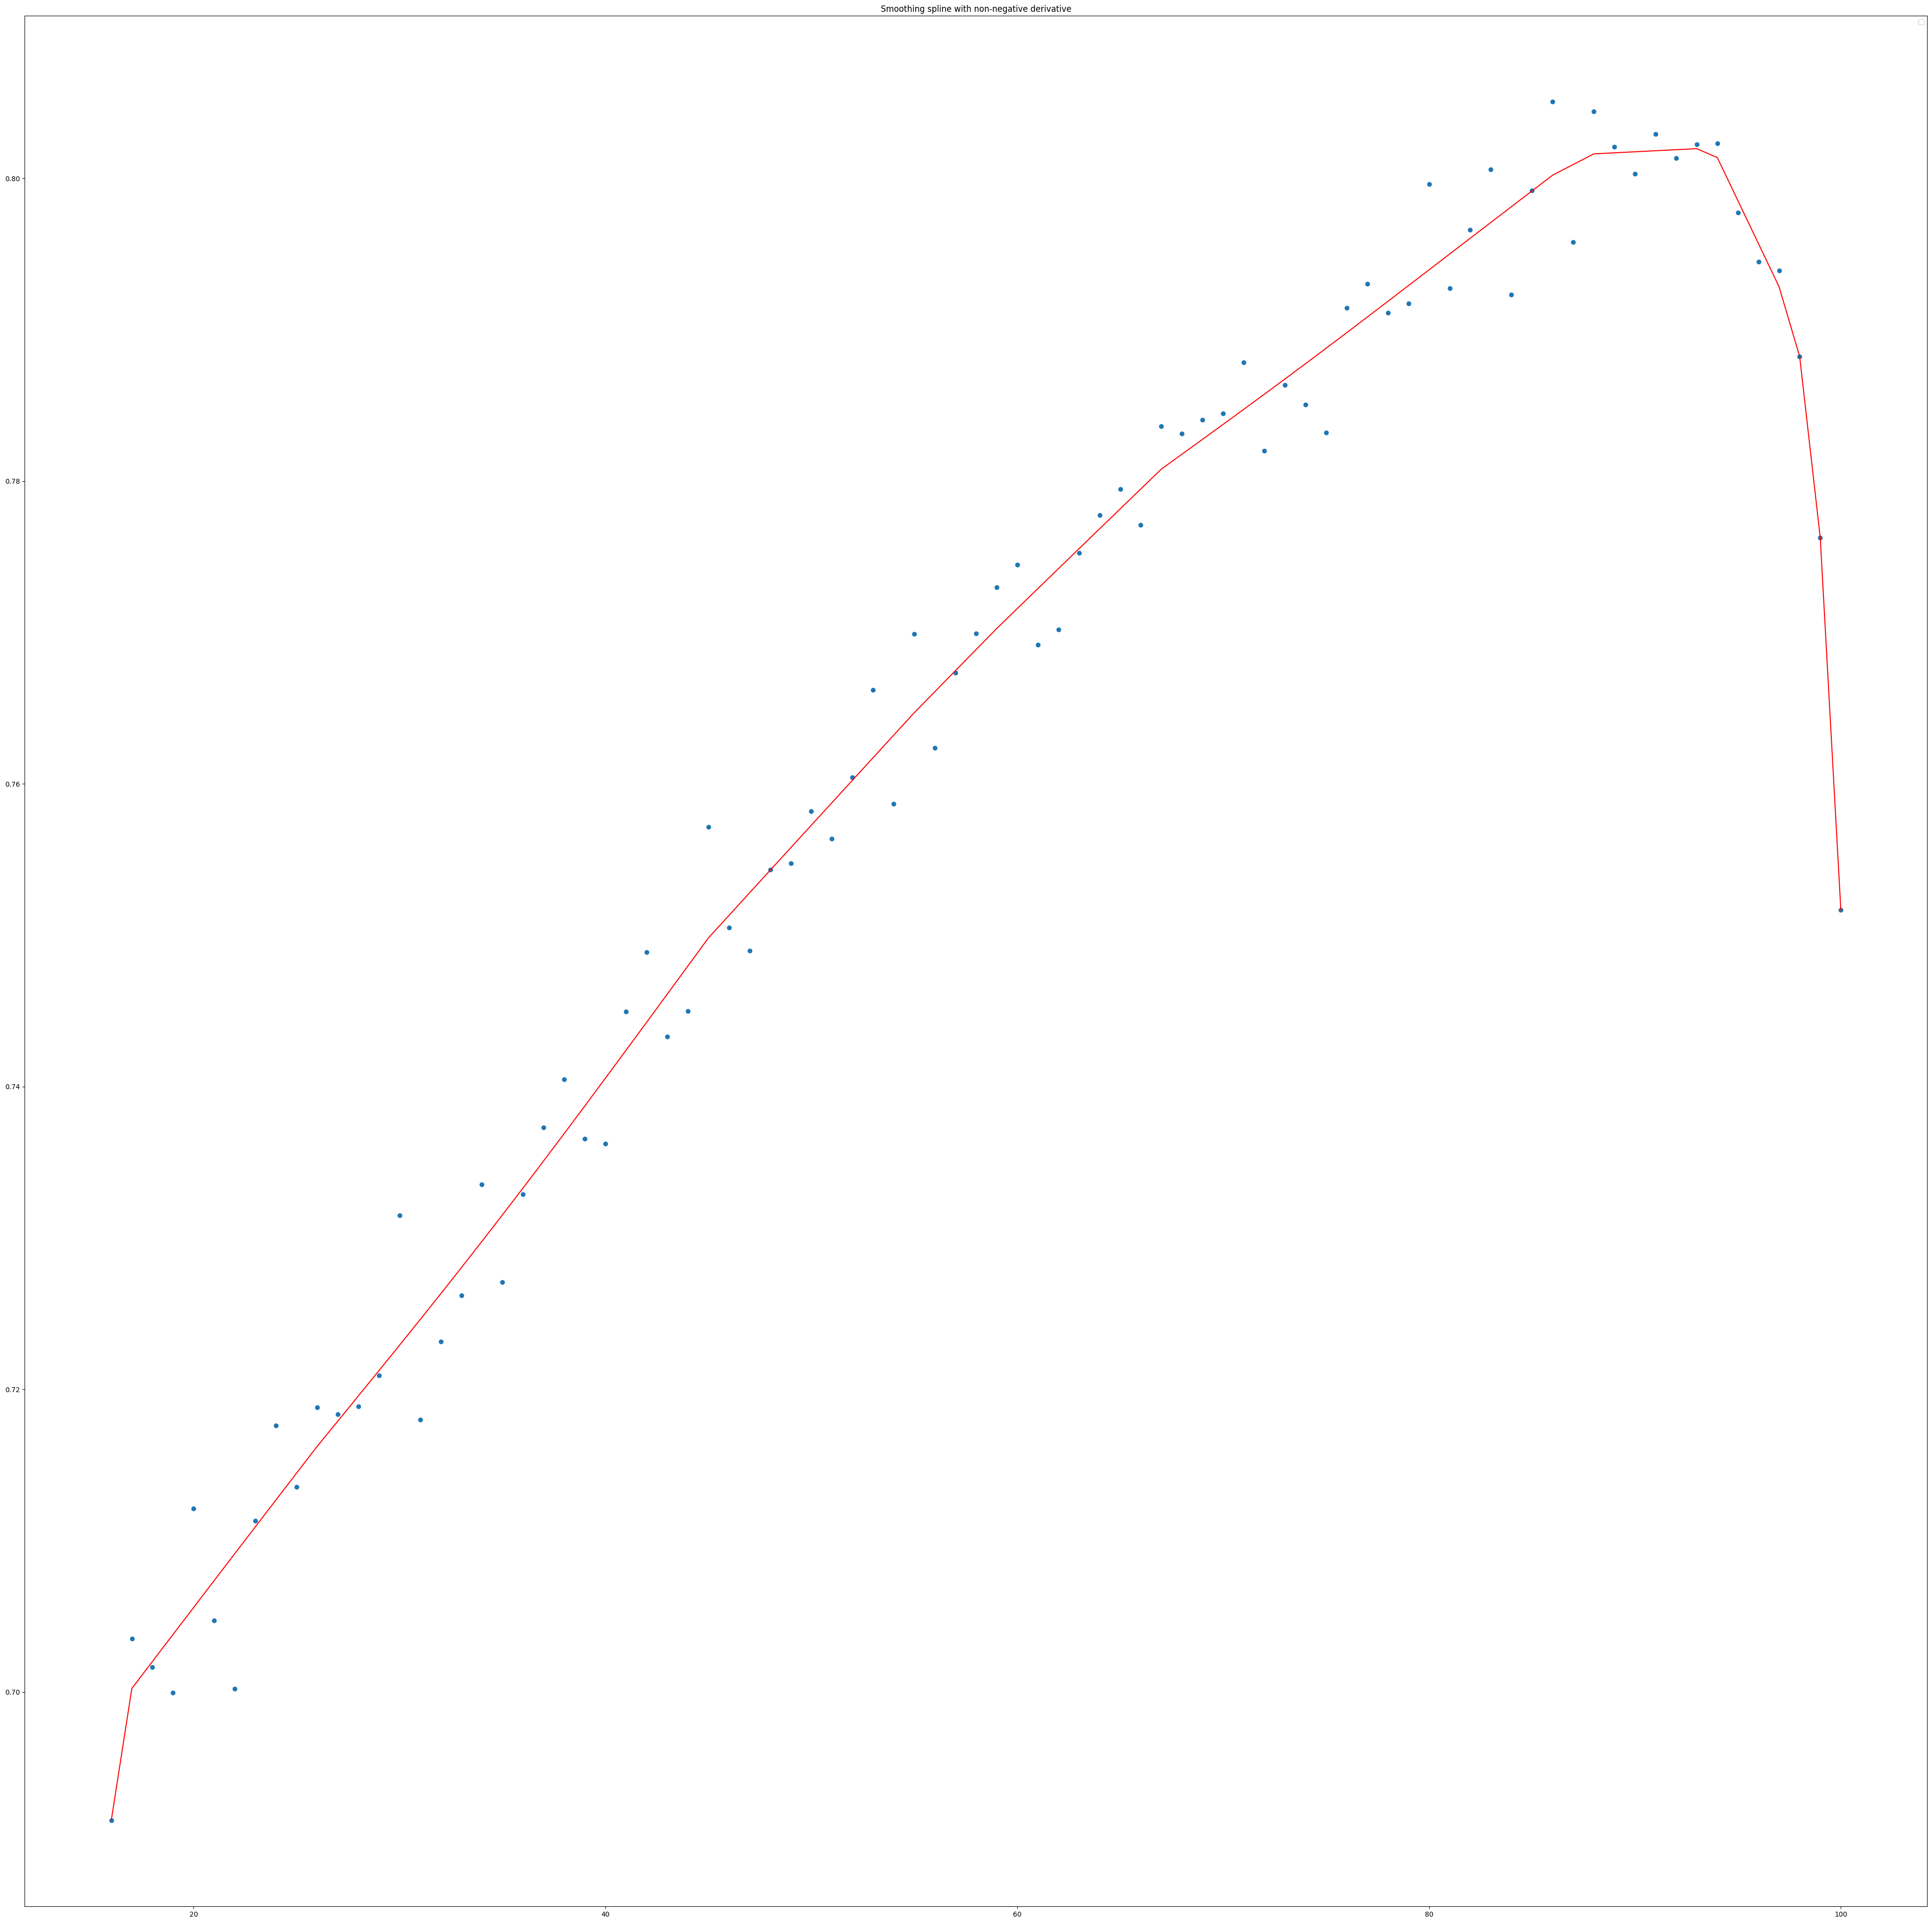

In [7]:
def plot_constrained_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(50, 50))
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
        
    n = len(x)

    # Sort x (just in case)
    sorted_idx = np.argsort(x)
    x = x[sorted_idx]
    y = y[sorted_idx]

    # Step size
    h = np.diff(x)

    # Variables: fitted y values at knots
    f = cp.Variable(n)
    second_diff = [(f[i+1] - 2*f[i] + f[i-1]) / ((h[i-1] + h[i-1]) / 2)**2 for i in range(1, n-1)]

    lambda_reg = 0 
    objective = cp.Minimize(cp.sum_squares(f - y) + lambda_reg * cp.sum_squares(cp.hstack(second_diff)))

    constraints = [d <= 0 for d in second_diff]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Plot
    ax.scatter(x, y)
    ax.plot(x, f.value, color='red')
    ax.legend()
    ax.set_title('Smoothing spline with non-negative derivative')

plot_constrained_spline(df=top_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle)


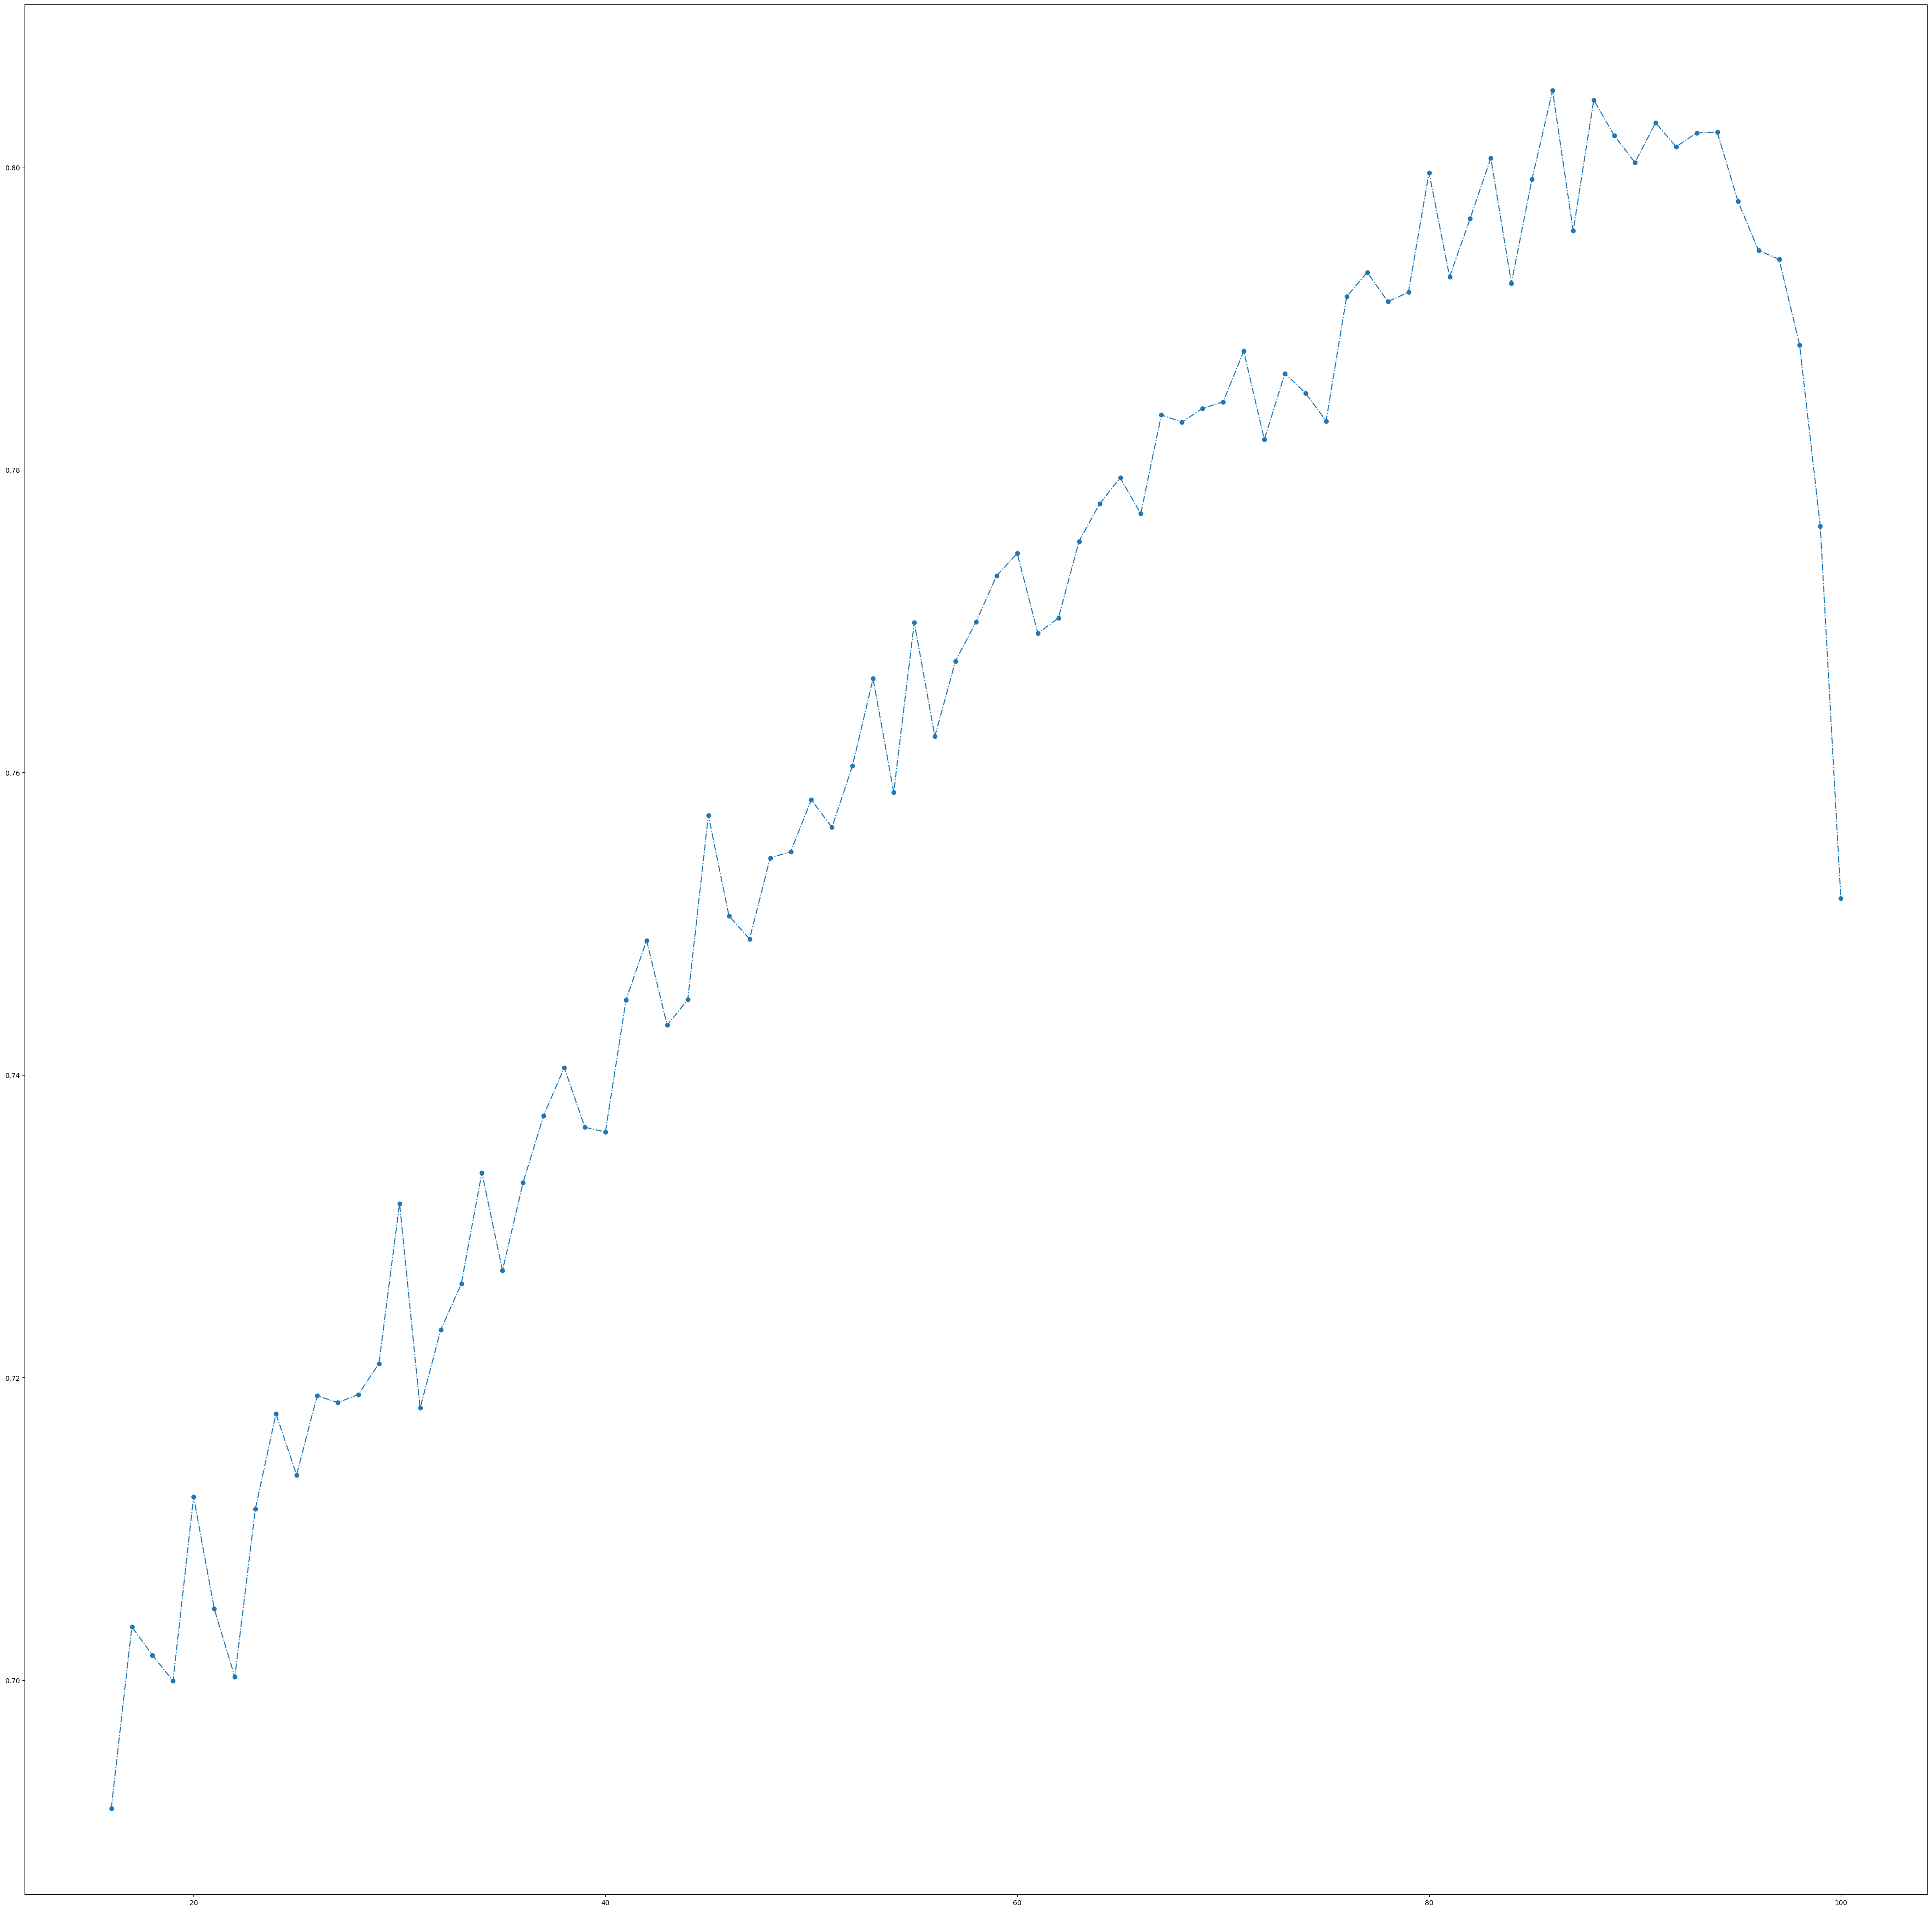

In [8]:
from scipy.interpolate import CubicSpline
def plot_cubic_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(50, 50))
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))


    ax.scatter(x,y)
    cs = CubicSpline(x, y)
    plt.plot(x, cs(x), '-.')


plot_cubic_spline(df=top_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle)

In [9]:
import scipy
print(scipy.__version__)

1.13.1


stdev is 0.010018960280124114
S is 0.010037956509470466


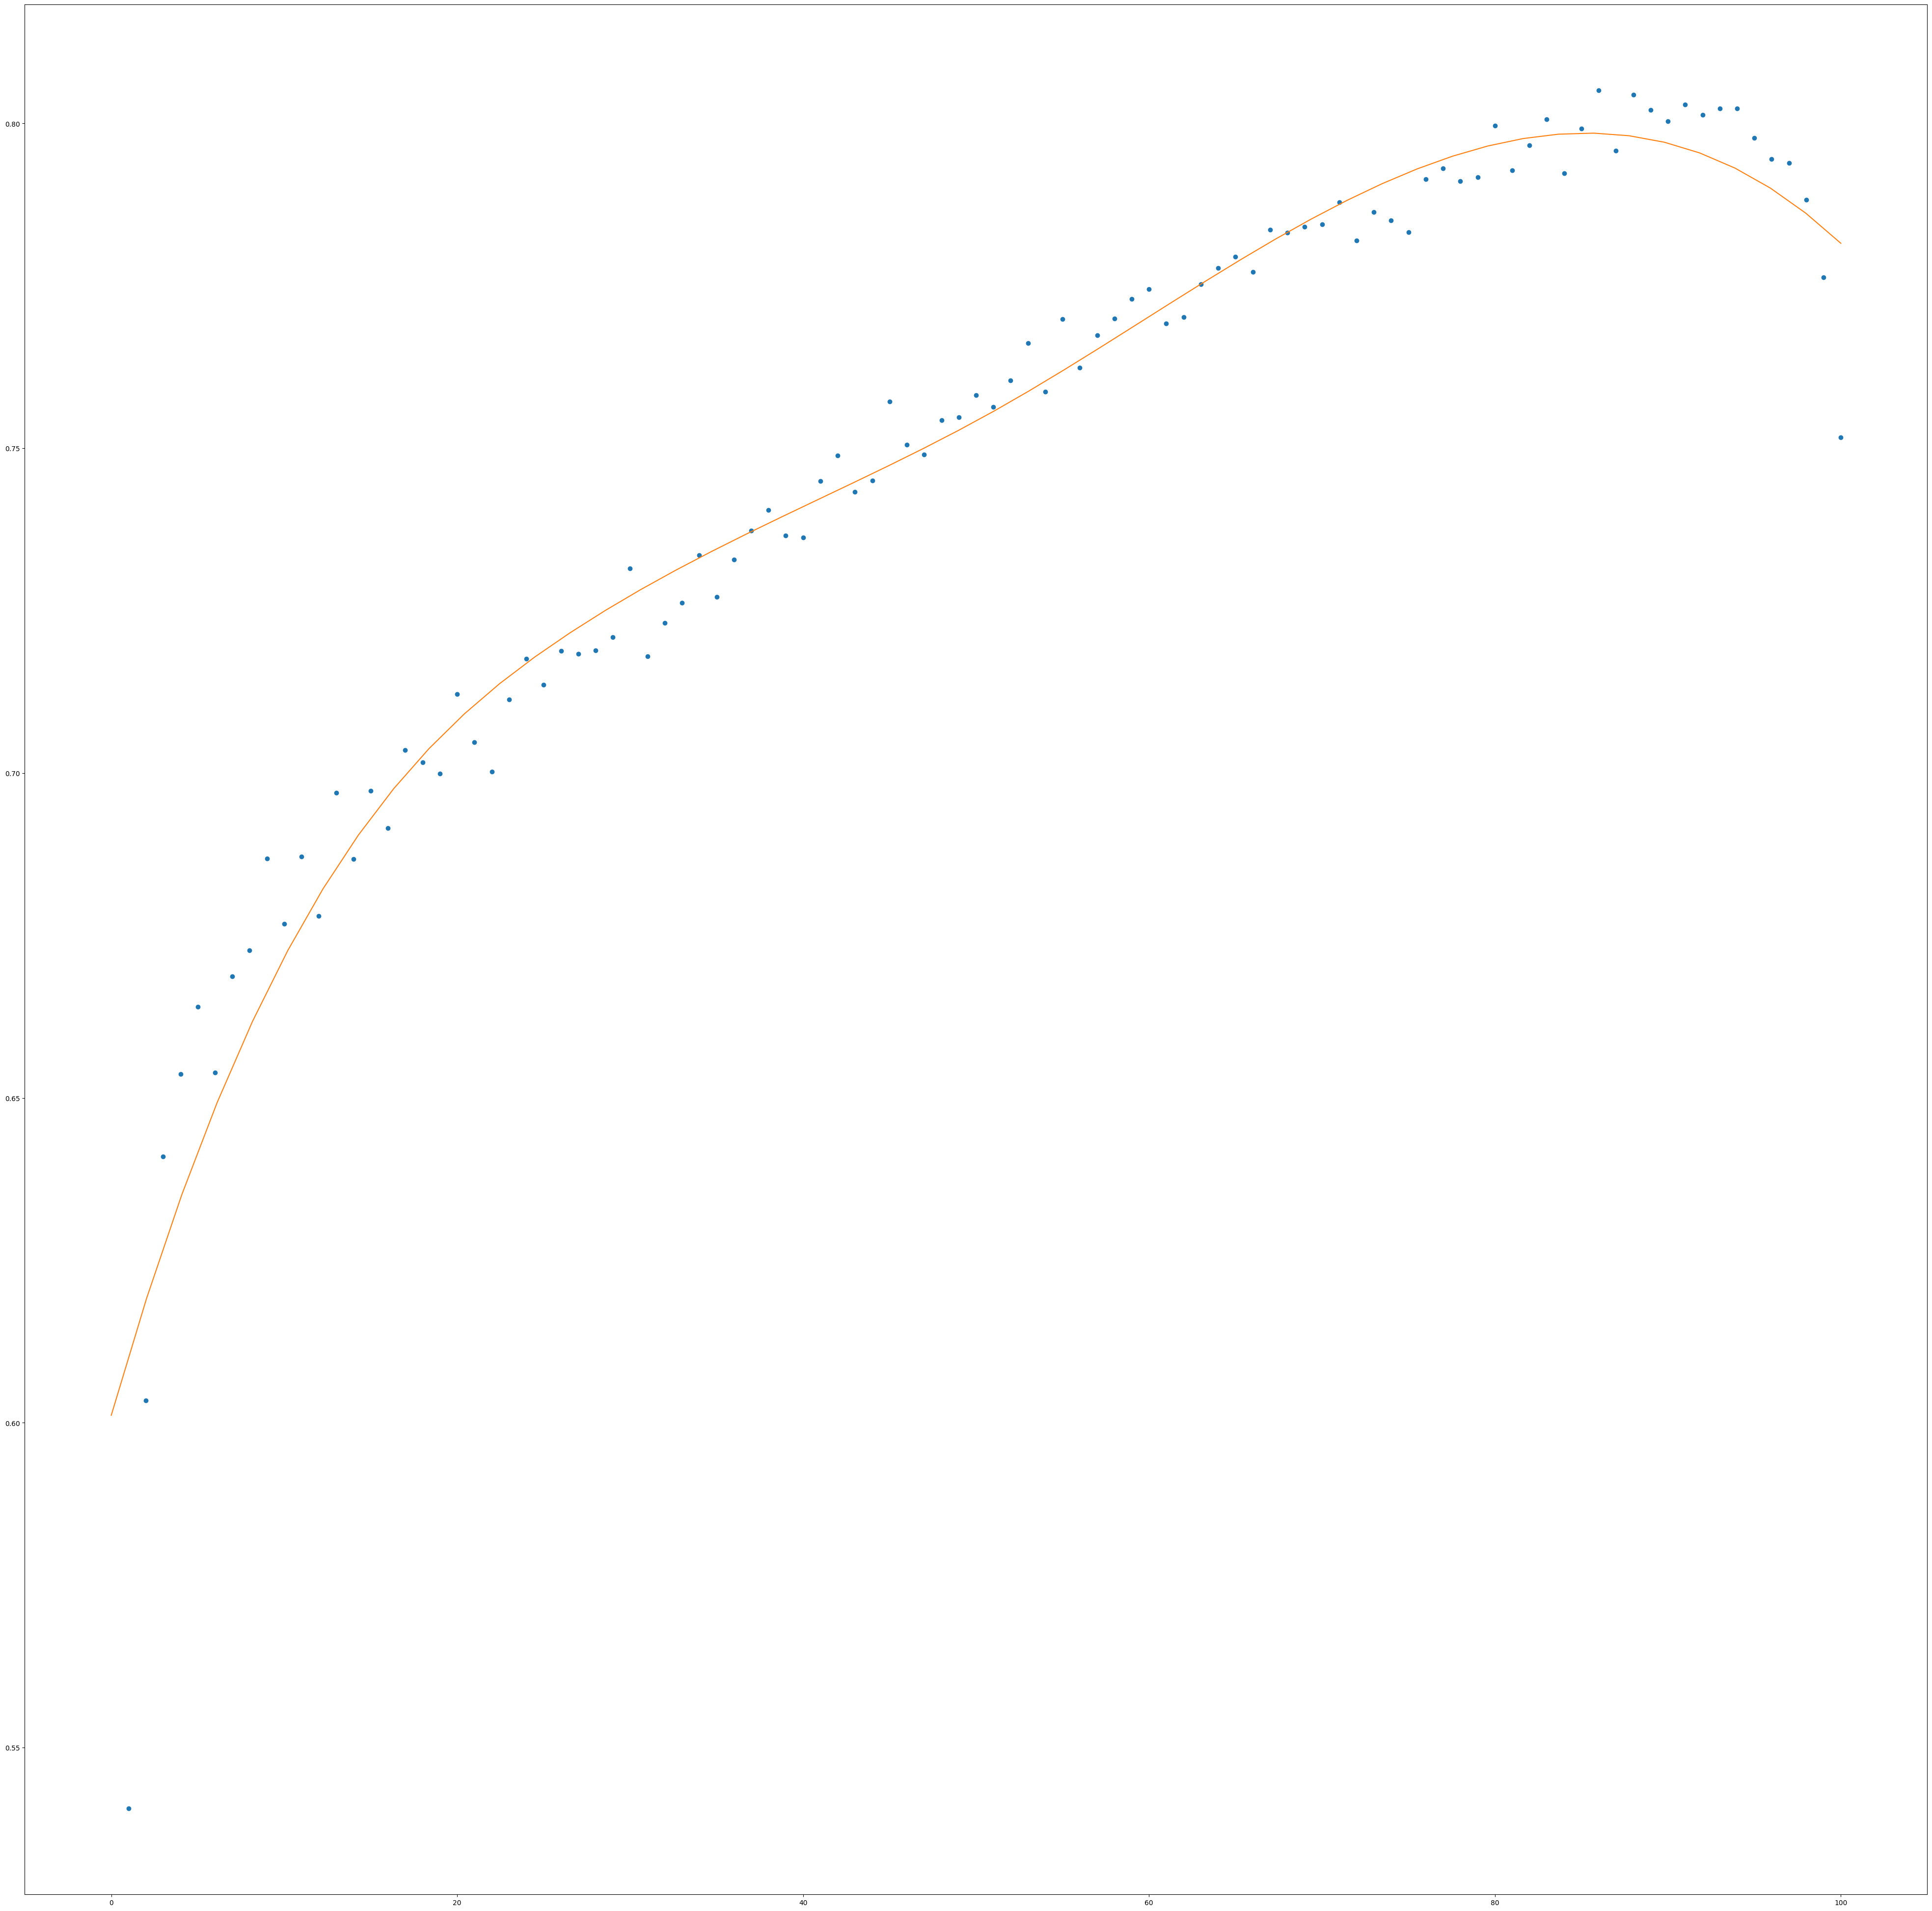

In [10]:
#created with this tutorial: https://docs.scipy.org/doc/scipy-1.13.1/tutorial/interpolate/smoothing_splines.html#tutorial-interpolate-splxxx
#
import statistics
from scipy.interpolate import splev, splrep
def plot_spline2(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(50, 50))
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values

    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        if c>0:
            yerr.append(1.96*s/math.sqrt(c))

    stdev=statistics.mean(yerr)
    
    print(f"stdev is {stdev}")
    s=float(len(x))*stdev*stdev
    print(f"S is {s}")
    #"If all weights equal unity, a reasonable choice might be around m*stdev^2, where  stdev is an estimate for the standard deviation of the data."
    #https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

    spl = splrep(x, y, s=  s)
    x2 = np.linspace(0, 100)
    y2 = splev(x2, spl)
    plt.plot(x, y, 'o', x2, y2)
    plt.show()


plot_spline2(df=df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle)

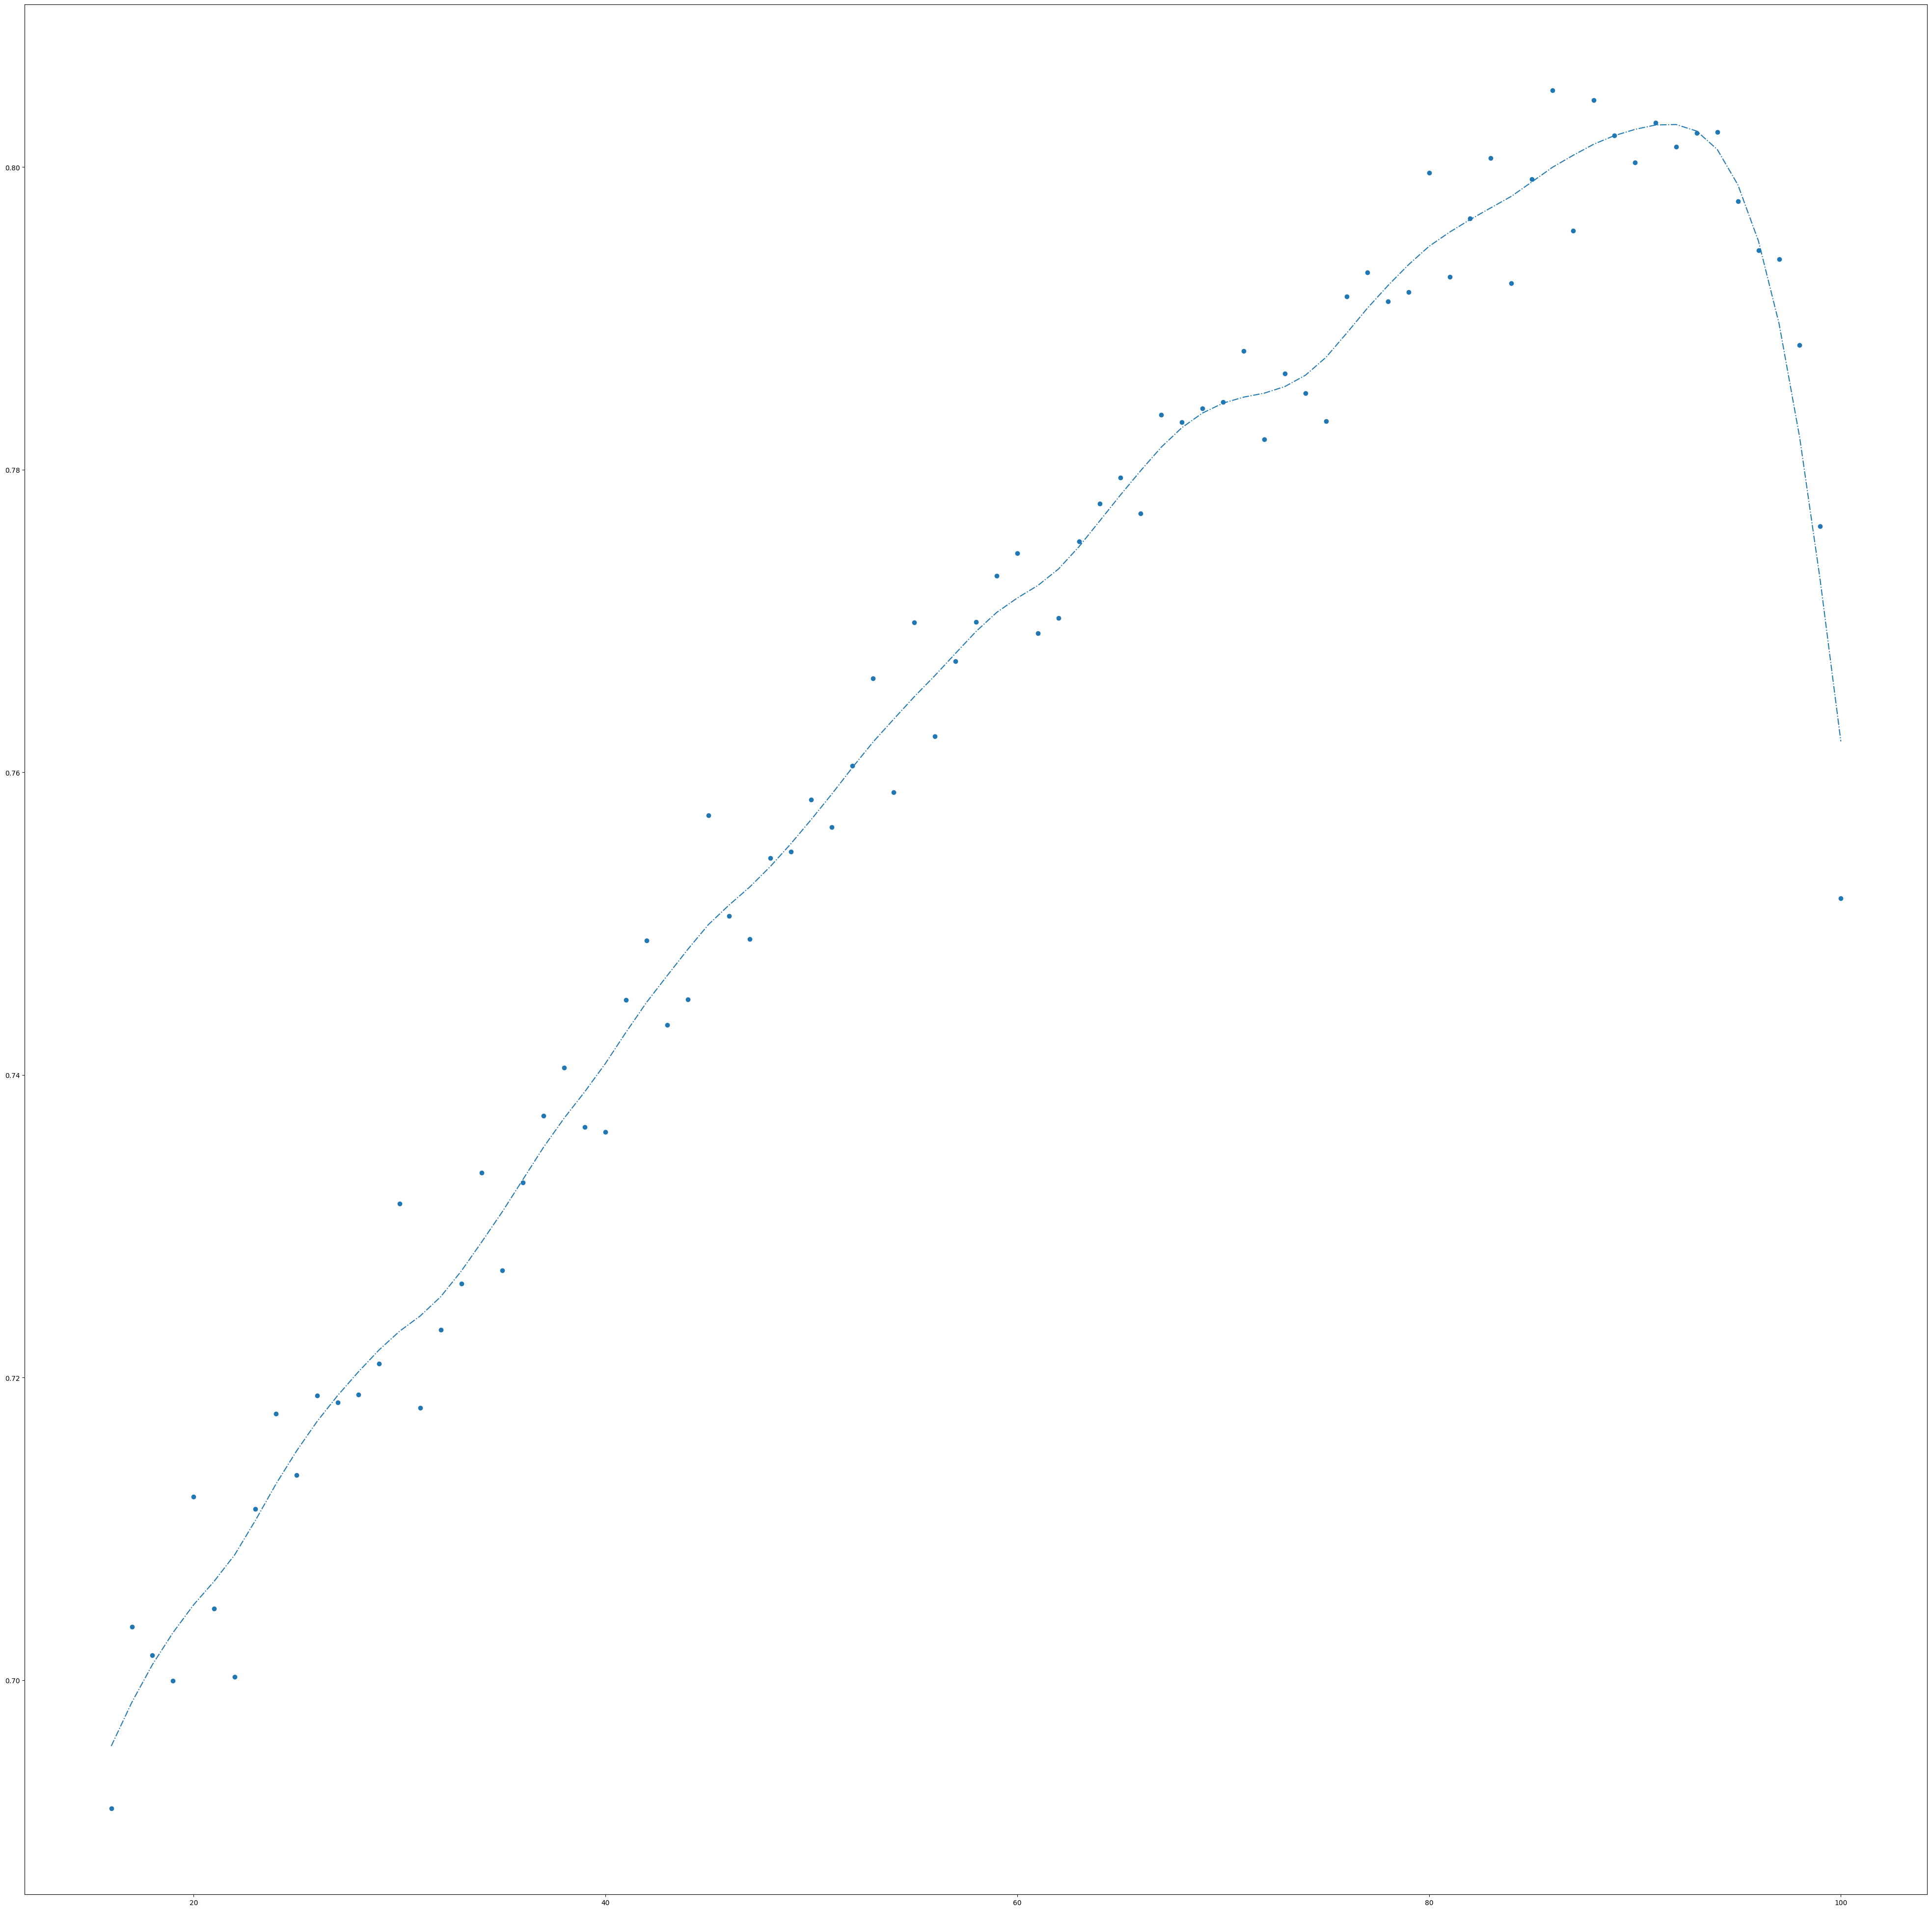

In [11]:
from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(50, 50))
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)
    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    plt.plot(x, spl(x), '-.')


plot_smooth_spline(df=top_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle)


# lm(y ~ poly(x, degree = 3, raw = TRUE), data = predict(spline_result, x = seq(3, 4, len = 10)))

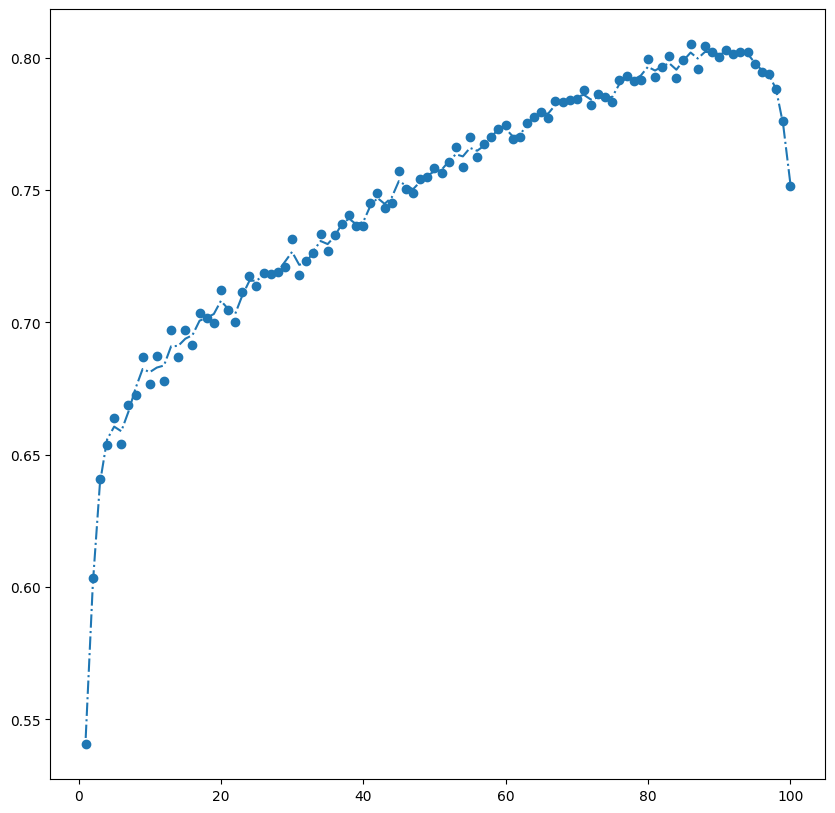

In [12]:
def plot_smooth_spline2(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False, figsize=(50,50)):
    if(ax is None):
        _, ax = plt.subplots(figsize=figsize)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    
    for lam in [0.1]:
        spl = make_smoothing_spline(x, y, lam=lam)
        plt.plot(x, spl(x), '-.', label=fr'$\lambda=${lam}')

examples_df["rank"]=100-examples_df["example_idx"]
compare_metric="example_comet"
plot_smooth_spline2(df=examples_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle, figsize=(10,10), error_bar=False)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.3642
Link Function:                     IdentityLink Log Likelihood:                              -1916827.7247
Number of Samples:                          100 AIC:                                          3833696.1779
                                                AICc:                                         3833707.2432
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                    0.993
Feature Function                  Lam

/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_50645/1220404873.py:21: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


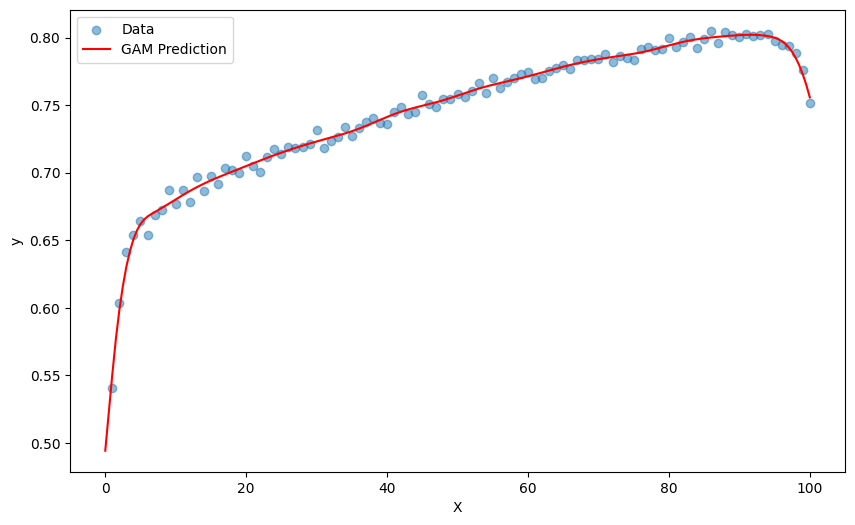

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pygam import LinearGAM, s




def plot_gam(df, compare_metric):
    grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()


    # Assuming df is your dataframe
    X = grouped["rank"].values.reshape(-1,1)
    y = grouped[compare_metric].values.reshape( -1)


    gam = LinearGAM(s(0)).gridsearch(X, y)

    gam.summary()

    X_pred = np.linspace(0, 100,200).reshape(-1, 1)
    y_pred = gam.predict(X_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, label='Data', alpha=0.5)
    plt.plot(X_pred, y_pred, label='GAM Prediction', color='red')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()



